In [1]:
import statistics
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import pandas as pd

nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julienh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/julienh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
with open('/Users/julienh/Desktop/McGillWork/PainLexicon/chronic_reddit_scraper/posts_data_20250110_152846.json', 'r') as file:
    data = json.load(file)

print(data[2])

{'title': 'Advise needed please…also a bit of a rant because I’m hanging on by a thread ', 'author': '-MetalKitty-', 'created_timestamp': '2024-12-09T04:15:57.791000+0000', 'score': '30', 'upvote_ratio': 0, 'content': "The doctor I had been seeing for 20 years retired and now I can't find a doctor that will prescribe my pain meds and I'll run out next week and seriously don't know what to do. Have seen one gp and three pain management doctors who all have a strict no opioids policy. Was told by one doctor that I can't just stop taking them because I'll have a heart attack.... have heart issues...and one said I won't die from withdrawal. I'm absolutely terrified, don't know what to do, my anxiety is through the roof and I’m very depressed", 'post_id': 't3_1ha1foo', 'comments': [{'thing_id': 't1_m15bbgg', 'depth': 0, 'parent_id': None, 'author': 'Conscious_Rule_308', 'text': 'Is there no one else in your retiring doctor’s office? If so that is who I would ask to titrate me off if they wo

In [3]:
"""
Extracts and concatenates text from posts, comments, and replies.

This code iterates through a list of post dictionaries, extracting the title,
content, and all associated comments and replies. It then concatenates these
text elements into a single string for each post and stores them in a list.
"""
posts_texts = []
for post in data:
    post_text = post["title"] + " " + post["content"]
    for comment in post["comments"]:
        post_text += " " + comment["text"]
        for reply in comment["replies"]:
            post_text += " " + reply["text"]
    posts_texts.append(post_text)

print(posts_texts[0])

Speech dictation is so horrible  :/ i understand the application of it is likely for more formal writings, but it’s so bad on my iPhone.. i feel really alienated among my friends because when my pain flares up i start typing all disjointed and not like myself… if you’re anything like me and housebound with lots of online friends, you know how important a tiny thing like your typing style is!! And there’s so many errors I have to go through and fix manually, because doing it with voice control is too difficult.  I’ve been using it for years now and it’s always been obnoxious.. this is probably the most relatable thing I've seen all day! yeah it's so annoying and when it spews out the most random words that are nowhere near what I'm trying to say it's just so frustrating :/hope you're having a day with less pain than usual OP :)


In [4]:
"""
Preprocesses text data by removing URLs, usernames, subreddit mentions,
punctuation, and special characters. It also converts text to lowercase,
lemmatizes words, and removes stop words.
"""
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Cleans and preprocesses a given text string.

    Args:
        text (str): The input text string.

    Returns:
        str: The preprocessed text string.
    """
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"u/\S+", "", text)  # Remove usernames
    text = re.sub(r"r/\S+", "", text)  # Remove subreddit mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation and special characters
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

cleaned_posts_texts = [preprocess_text(post_text) for post_text in posts_texts]

In [5]:
# save cleaned posts texts to file
with open('cleaned_posts_texts.txt', 'w') as file:
    for text in cleaned_posts_texts:
        file.write(text + "\n")


In [7]:
# lets get some simple statistics 
print(f"Number of posts: {len(cleaned_posts_texts)}")
print(f"Number of unique words: {len(set(word for text in cleaned_posts_texts for word in text.split()))}")
print(f"Number of words: {sum(len(text.split()) for text in cleaned_posts_texts)}")

Number of posts: 1786
Number of unique words: 37193
Number of words: 675375


In [28]:
# number of words per post analysis
word_counts = [len(text.split()) for text in cleaned_posts_texts]
print(f"Average words per post: {sum(word_counts) / len(word_counts)}")
print(f"Median words per post: {statistics.median(word_counts)}")
print(f"Longest post (word count): {max(word_counts)}")
print(f"Shortest post (word count): {min(word_counts)}")


Average words per post: 378.1494960806271
Median words per post: 225.0
Longest post (word count): 7906
Shortest post (word count): 0


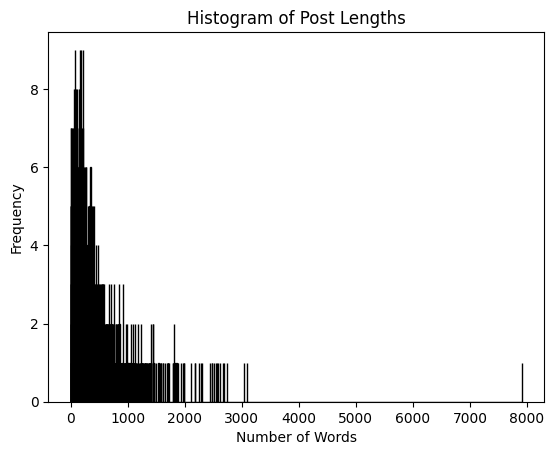

In [30]:
# create a histogram of word lengths
plt.hist(word_counts, bins=range(1, max(word_counts) + 1), edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Post Lengths')
plt.show()


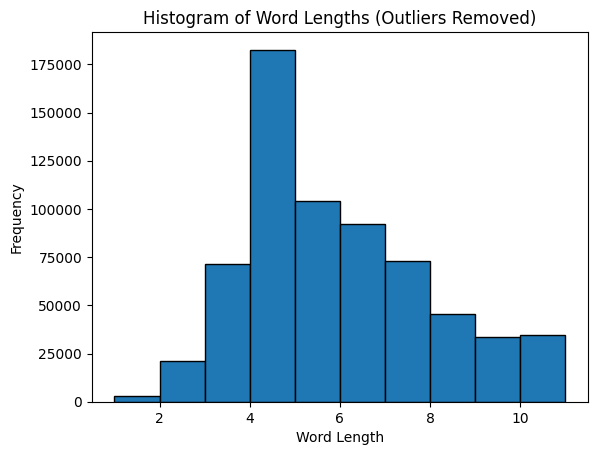

In [33]:
def plot_word_length_histogram(cleaned_posts_texts):
    """
    Generates and displays a histogram of word lengths from a list of cleaned text posts,
    removing outliers based on the IQR.

    Args:
        cleaned_posts_texts (list): A list of strings, where each string is a cleaned text post.
    """
    # concatenate all the posts texts into a single string
    all_text = " ".join(cleaned_posts_texts)
    # create a histogram of word lengths    
    word_lengths = [len(word) for word in all_text.split()]

    # Calculate the IQR
    Q1 = statistics.quantiles(word_lengths, n=4)[0]
    Q3 = statistics.quantiles(word_lengths, n=4)[2]
    IQR = Q3 - Q1

    # Define bounds for outlier removal
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    filtered_word_lengths = [length for length in word_lengths if lower_bound <= length <= upper_bound]


    plt.hist(filtered_word_lengths, bins=range(1, max(filtered_word_lengths) + 1), edgecolor='black')
    plt.xlabel('Word Length')
    plt.ylabel('Frequency')
    plt.title('Histogram of Word Lengths (Outliers Removed)')
    plt.show()

plot_word_length_histogram(cleaned_posts_texts)


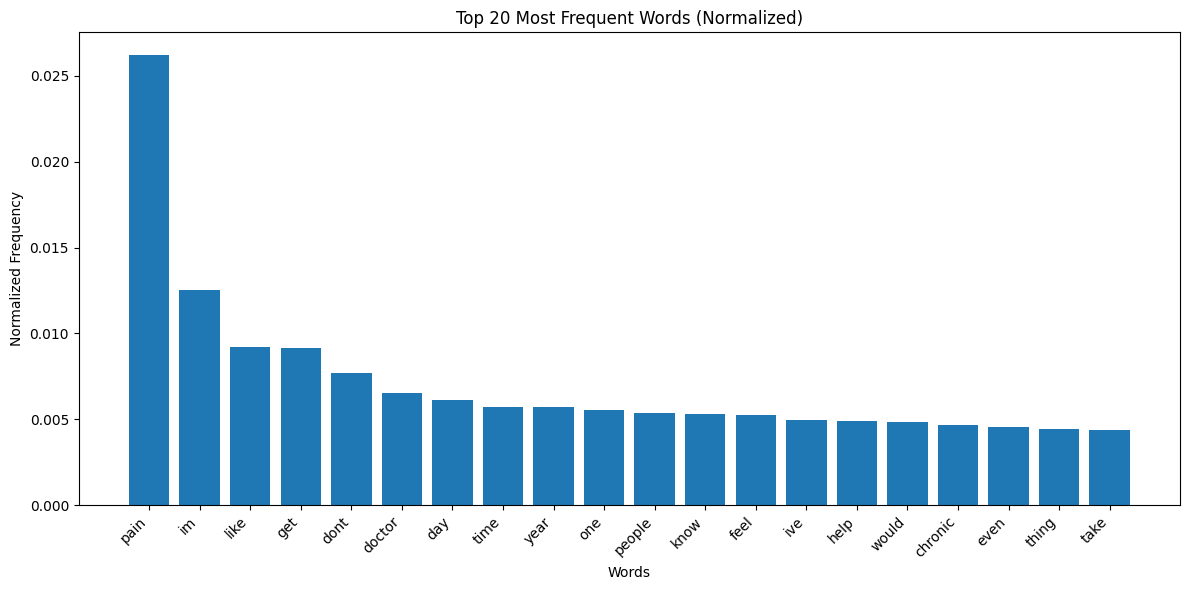

In [8]:
from collections import Counter

def plot_top_words(cleaned_texts, n=20):
    """
    Creates a bar chart of the n most frequent words.
    """
    # Get word frequencies
    words = ' '.join(cleaned_texts).split()
    word_counts = Counter(words)
    
    # Normalize frequencies
    total_words = len(words)
    word_freq = [(word, count / total_words) for word, count in word_counts.most_common(n)]
    
    # Prepare data for plotting
    words, frequencies = zip(*word_freq)
    
    # Create bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(words, frequencies)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Normalized Frequency')
    plt.title(f'Top {n} Most Frequent Words (Normalized)')
    plt.tight_layout()
    plt.show()

plot_top_words(cleaned_posts_texts)

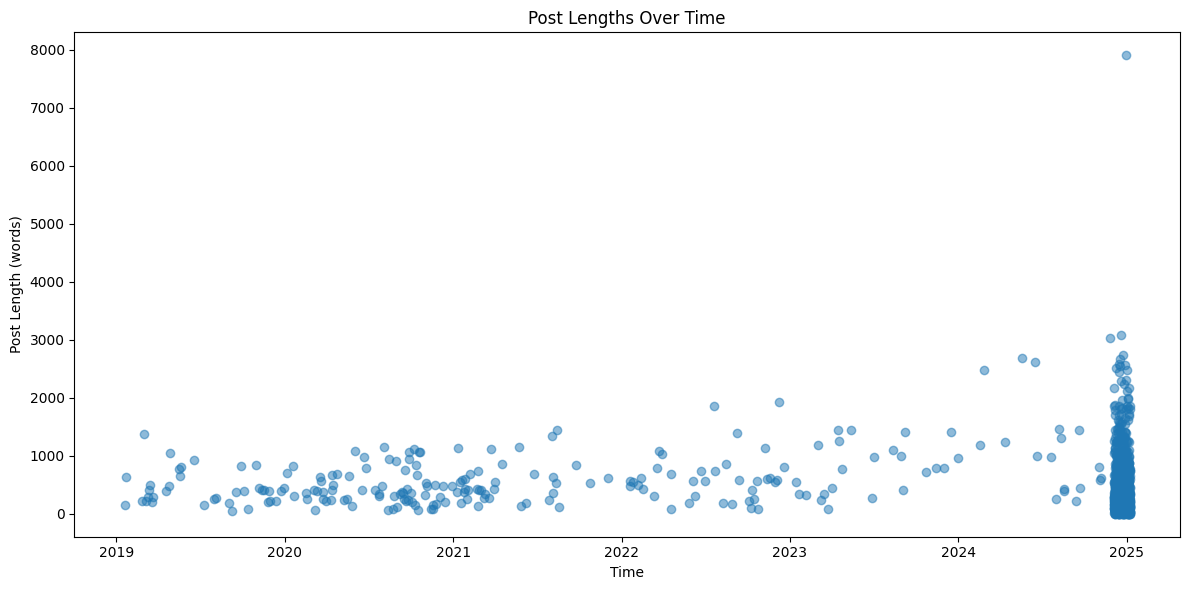

In [9]:
def plot_post_lengths_over_time(data):
    """
    Creates a scatter plot of post lengths over time.
    """
    # Extract timestamps and lengths
    timestamps = [pd.to_datetime(post['created_timestamp']) for post in data]
    lengths = [len(text.split()) for text in cleaned_posts_texts]
    
    plt.figure(figsize=(12, 6))
    plt.scatter(timestamps, lengths, alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Post Length (words)')
    plt.title('Post Lengths Over Time')
    plt.tight_layout()
    plt.show()

plot_post_lengths_over_time(data)


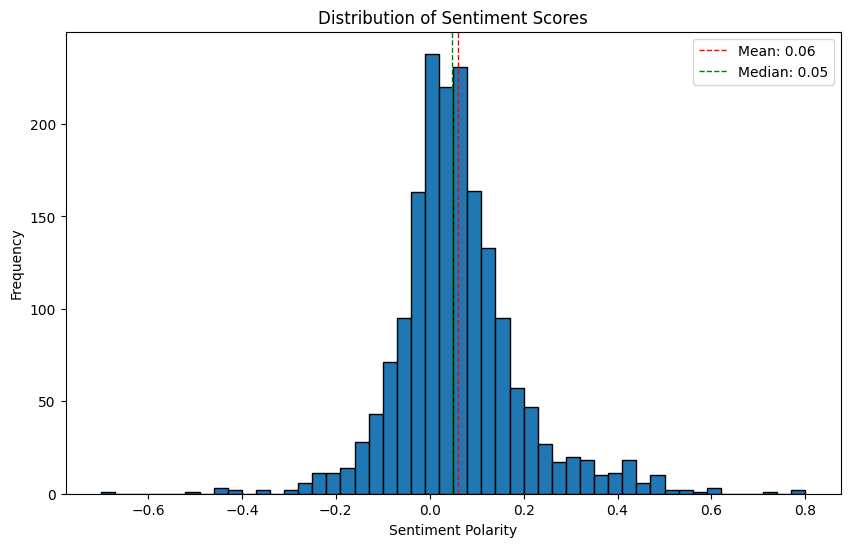

In [13]:
from textblob import TextBlob
import numpy as np

def plot_sentiment_distribution(texts):
    """
    Creates a histogram of sentiment polarity scores, with mean and median lines.
    """
    sentiments = [TextBlob(text).sentiment.polarity for text in texts]
    
    plt.figure(figsize=(10, 6))
    plt.hist(sentiments, bins=50, edgecolor='black')
    
    mean_sentiment = np.mean(sentiments)
    median_sentiment = np.median(sentiments)
    
    plt.axvline(mean_sentiment, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_sentiment:.2f}')
    plt.axvline(median_sentiment, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_sentiment:.2f}')
    
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sentiment Scores')
    plt.legend()
    plt.show()

plot_sentiment_distribution(cleaned_posts_texts)

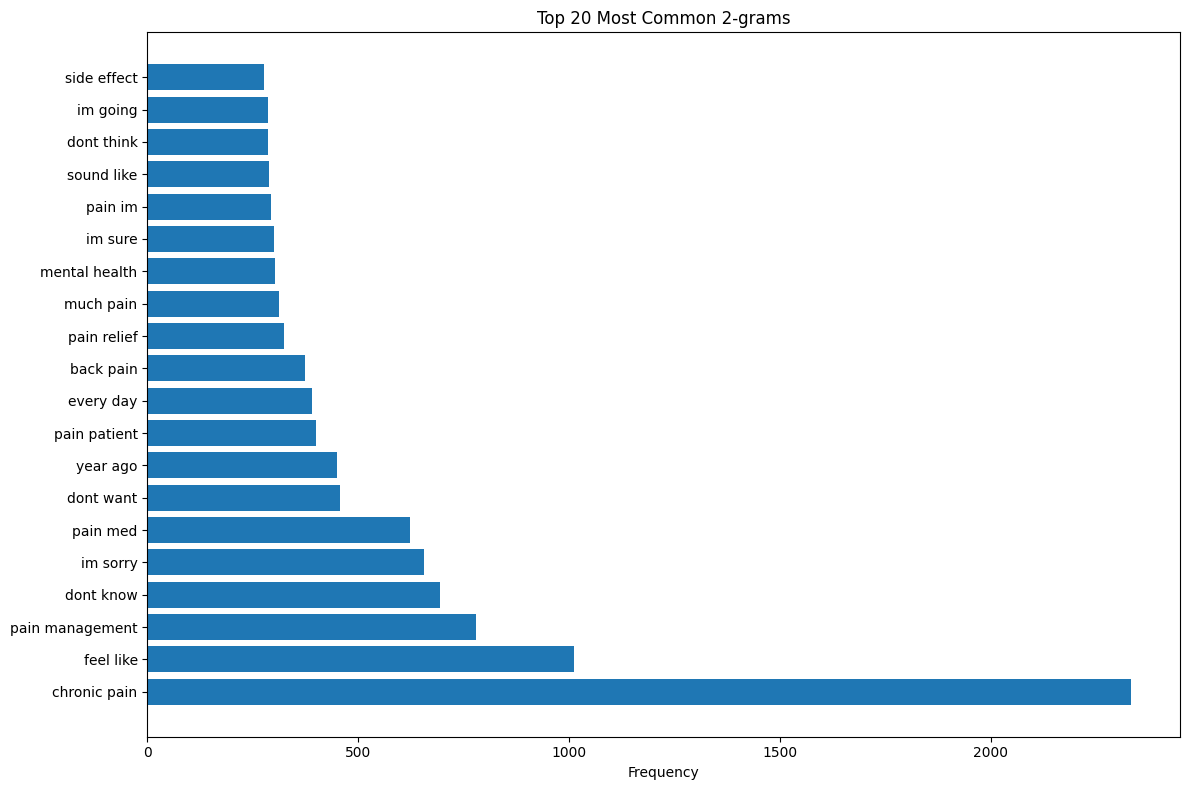

In [11]:
from nltk import ngrams

def plot_top_ngrams(texts, n=2, top_k=20):
    """
    Creates a horizontal bar chart of the most common n-grams.
    """
    # Combine all texts and generate n-grams
    words = ' '.join(texts).split()
    n_grams = list(ngrams(words, n))
    n_gram_freq = Counter(n_grams).most_common(top_k)
    
    # Prepare data for plotting
    labels = [' '.join(gram) for gram, _ in n_gram_freq]
    values = [count for _, count in n_gram_freq]
    
    # Create horizontal bar plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(labels)), values)
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('Frequency')
    plt.title(f'Top {top_k} Most Common {n}-grams')
    plt.tight_layout()
    plt.show()

plot_top_ngrams(cleaned_posts_texts)

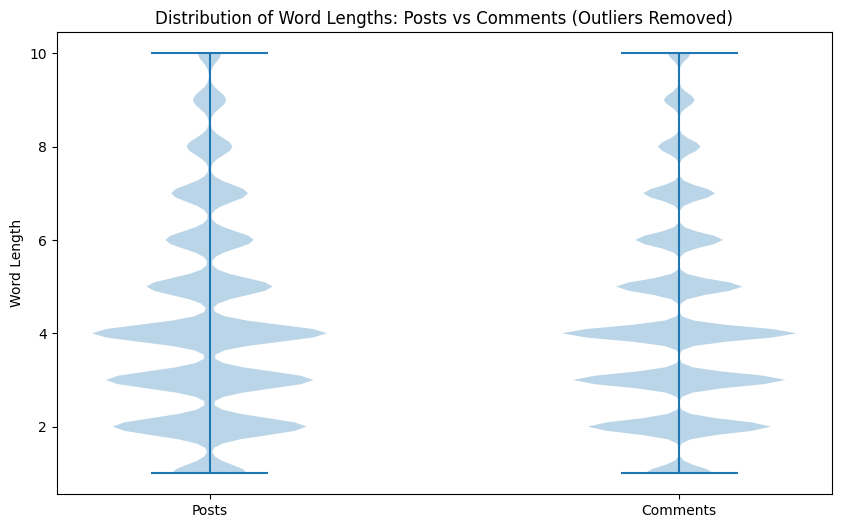

In [45]:
import numpy as np

def plot_word_length_comparison(data):
    """
    Creates a violin plot comparing word lengths in posts vs comments, removing outliers.
    """
    # Separate posts and comments
    post_lengths = []
    comment_lengths = []
    
    for post in data:
        # Get post word lengths
        post_words = (post['title'] + ' ' + post['content']).split()
        post_lengths.extend([len(word) for word in post_words])
        
        # Get comment word lengths
        for comment in post['comments']:
            comment_words = comment['text'].split()
            comment_lengths.extend([len(word) for word in comment_words])
    
    # Function to remove outliers using IQR
    def remove_outliers(lengths):
        q1 = np.percentile(lengths, 25)
        q3 = np.percentile(lengths, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return [length for length in lengths if lower_bound <= length <= upper_bound]

    # Remove outliers
    post_lengths_filtered = remove_outliers(post_lengths)
    comment_lengths_filtered = remove_outliers(comment_lengths)
    
    # Create violin plot
    plt.figure(figsize=(10, 6))
    plt.violinplot([post_lengths_filtered, comment_lengths_filtered])
    plt.xticks([1, 2], ['Posts', 'Comments'])
    plt.ylabel('Word Length')
    plt.title('Distribution of Word Lengths: Posts vs Comments (Outliers Removed)')
    plt.show()

plot_word_length_comparison(data)

In [6]:
# LDA with Gensim
from gensim import corpora
from gensim.models import LdaModel

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary([text.split() for text in cleaned_posts_texts])
# Filter out extremes (similar to the min_df and max_df parameters in sklearn)
dictionary.filter_extremes(no_below=5, no_above=0.5)  #  
# Create a bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(text.split()) for text in cleaned_posts_texts]
# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=10)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")


Topic: 0 
Words: 0.008*"people" + 0.006*"good" + 0.006*"youre" + 0.006*"see" + 0.006*"want" + 0.005*"say" + 0.005*"med" + 0.005*"work" + 0.005*"could" + 0.004*"look"

Topic: 1 
Words: 0.011*"people" + 0.006*"patient" + 0.006*"drug" + 0.006*"life" + 0.006*"u" + 0.005*"med" + 0.005*"want" + 0.005*"work" + 0.005*"medication" + 0.005*"many"

Topic: 2 
Words: 0.009*"people" + 0.007*"life" + 0.006*"still" + 0.005*"hurt" + 0.005*"bad" + 0.004*"way" + 0.004*"got" + 0.004*"body" + 0.004*"worse" + 0.004*"better"

Topic: 3 
Words: 0.005*"got" + 0.005*"told" + 0.004*"could" + 0.004*"work" + 0.004*"say" + 0.004*"didnt" + 0.004*"want" + 0.004*"see" + 0.004*"said" + 0.004*"still"

Topic: 4 
Words: 0.006*"surgery" + 0.006*"med" + 0.005*"work" + 0.005*"good" + 0.005*"use" + 0.005*"want" + 0.005*"week" + 0.005*"got" + 0.004*"relief" + 0.004*"better"



In [7]:
import pyLDAvis.gensim_models
import pyLDAvis

# Assuming you have your trained LDA model (lda_model) and corpus from the previous examples:

# Prepare the visualization data
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

# Display the visualization in your browser
#pyLDAvis.display(vis_data)

# You can also save it as an HTML file:
pyLDAvis.save_html(vis_data, 'lda_visualization.html')

## Bert Topic Modelling and Analysis

In [46]:

# BERTopic
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=False, verbose=True)
topics, _ = topic_model.fit_transform(cleaned_posts_texts)

# Get the topics
topic_model.get_topic_info()
# Print the top 10 most frequent topics
print(topic_model.get_topic_info().head(10))

# Get the top n terms per topic
n_terms = 5
for i in range(len(set(topics)) - 1):  # Exclude outlier topic -1
    print(f"Topic {i}: {topic_model.get_topic(i)[:n_terms]}\n")

2025-01-10 21:52:47,321 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/56 [00:00<?, ?it/s]

2025-01-10 21:52:54,434 - BERTopic - Embedding - Completed ✓
2025-01-10 21:52:54,435 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-10 21:52:57,369 - BERTopic - Dimensionality - Completed ✓
2025-01-10 21:52:57,369 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-10 21:52:57,407 - BERTopic - Cluster - Completed ✓
2025-01-10 21:52:57,412 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-10 21:52:57,688 - BERTopic - Representation - Completed ✓


   Topic  Count                            Name  \
0     -1    782             -1_pain_im_like_get   
1      0    181            0_pain_take_med_drug   
2      1    104           1_im_people_pain_like   
3      2     97      2_people_pain_patient_drug   
4      3     73       3_disc_back_spine_surgery   
5      4     59        4_doctor_pain_im_patient   
6      5     44              5_pain_knee_im_ive   
7      6     40  6_pharmacy_pharmacist_med_fill   
8      7     37             7_thc_cbd_weed_pain   
9      8     35  8_christmas_merry_holiday_gift   

                                      Representation  \
0  [pain, im, like, get, dont, feel, day, year, t...   
1  [pain, take, med, drug, doctor, mg, dose, get,...   
2  [im, people, pain, like, dont, feel, day, frie...   
3  [people, pain, patient, drug, opioids, doctor,...   
4  [disc, back, spine, surgery, neck, nerve, pain...   
5  [doctor, pain, im, patient, year, like, medica...   
6  [pain, knee, im, ive, get, like, leg, year,

In [47]:
fig = topic_model.visualize_topics()
fig.show()

In [48]:
fig = topic_model.visualize_hierarchy()
fig.show()

In [50]:
fig = topic_model.visualize_heatmap()
fig.show()

In [51]:
fig = topic_model.visualize_barchart(top_n_topics=10)
fig.show()

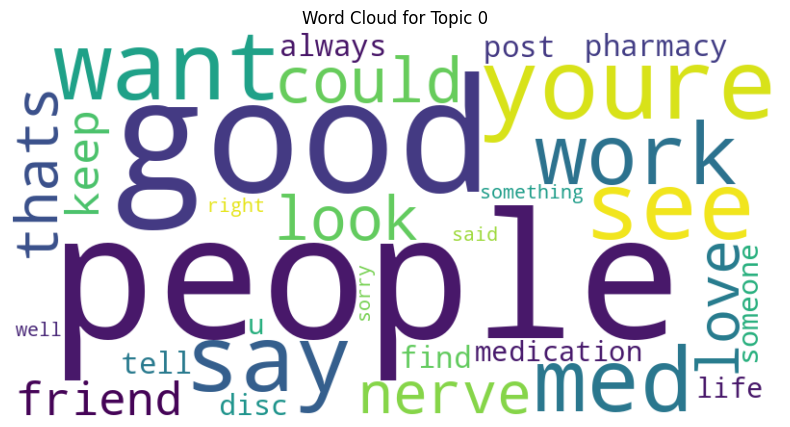

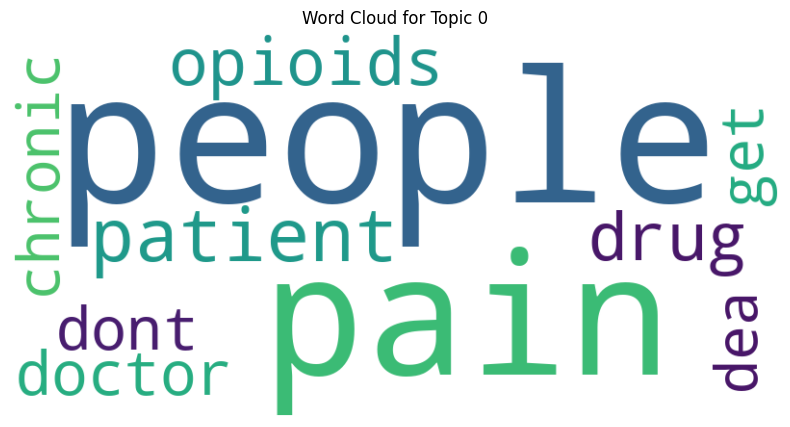

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud_for_topic(topic_id, model, num_words=30):
    """
    Generates a word cloud for a specific topic.

    Args:
        topic_id: The ID of the topic.
        model: The trained LDA or BERTopic model.
        num_words: The number of top words to include in the word cloud.
    """

    if isinstance(model, LdaModel):
        # For Gensim LDA model
        words = dict(model.show_topic(topic_id, num_words))
    elif isinstance(model, BERTopic):
        # For BERTopic model
        words = {word: prob for word, prob in model.get_topic(topic_id)}
    else:
        raise ValueError("Unsupported model type")

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_id}")
    plt.show()

# Example usage with LDA:
create_wordcloud_for_topic(0, lda_model)  # Create a word cloud for topic 0

# Example usage with BERTopic:
create_wordcloud_for_topic(0, topic_model)  # Create a word cloud for topic 0

In [10]:
from umap import UMAP
from bertopic import BERTopic
import plotly.express as px
import pandas as pd

# Assuming you have already trained your BERTopic model (topic_model) 
# and have your cleaned_posts_texts

# Get embeddings from the topic model
embeddings = topic_model.embedding_model.embed(cleaned_posts_texts)

# 1. Reduce dimensionality with UMAP (recommended)
umap_model = UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

# 2. Visualize reduced embeddings
# For interactive plots use visualize_documents
# topic_model.visualize_documents(docs=cleaned_posts_texts, embeddings=embeddings, reduced_embeddings=reduced_embeddings)

# For static plots you can use matplotlib:
topics = topic_model.topics_

# Prepare the data for plotting
df = pd.DataFrame({"x": reduced_embeddings[:, 0], "y": reduced_embeddings[:, 1], "topic": topics})

# Create the plot
fig = px.scatter(df, x="x", y="y", color="topic", hover_data=["topic"], title="t-SNE Visualization of Document Embeddings")

# Customize the layout
fig.update_layout(
    xaxis_title="Dimension 1",
    yaxis_title="Dimension 2",
    legend_title="Topic",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)

fig.show()